# 0) Introduction

This notebook will show you how to use CNN to classify case of pneumonia from chest-X ray images from [this dataset](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia/download) .  
It contains 5856 scans with various size that we will reshape to $128\times128\times3$. We use 3 channels for compatibility with pre-trained networks.    
To classify these scans, we will use Transfer Learning with an EfficientNetB0, that will then be Fine Tuned to improve even more our results.  

Our solution obtain a recall and a precision of about 0.98 on the test set.

# 1) Input preparation

In [323]:
import numpy as np
import os
import cv2
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
import glob
from pathlib import Path

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [338]:
def get_inputs(filepath):
    X = []
    for file in filepath:
        img = mpimg.imread(file)
        resized_img = cv2.resize(img, (64, 64))#We resize them to 128*128
        if len(resized_img.shape)!=3: #Some images have 3 identical channels instead of 1
            resized_img = np.stack((resized_img, resized_img, resized_img), axis=-1)

        X.append(resized_img)
    X = np.array(X)
    
    y=[]
    for file in filepath:
        if "NORMAL" in file:
            y.append(0)
        if "PNEUMONIA" in file:
            y.append(1)
    y = np.expand_dims(y, axis=-1)
    
    return X, y

def type_pred(list_true, list_pred):
    TP, FP, TN, FN = 0, 0, 0, 0
    for y_true, y_pred in zip(list_true, list_pred):
        if not y_true and not y_pred:
            TN+=1
        elif not y_true:
            FP+=1
        elif not y_pred:
            FN+=1
        else:
            TP+=1
    return TP, FP, TN, FN

def get_scores(list_true, list_pred):
    TP, FP, TN, FN = type_pred(list_true, list_pred)
    precision = TP/(TP+FP)
    recall = TP/(TP+FN)
    F1_score = 2*(precision*recall)/(precision+recall)
    return precision, recall, F1_score

As the validation set contains only 16 images, we are going to recreate a validation and test set with a (80/10/10) partition :  

In [339]:
filepath = glob.glob('chest_xray/train/*/*')+glob.glob('chest_xray/val/*/*')+glob.glob('chest_xray/test/*/*')
X, y = get_inputs(filepath)

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.2, random_state=0)
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=0)

In [340]:
print (X_train.shape, X_valid.shape, X_test.shape)
print (y_train.shape, y_valid.shape, y_test.shape)

(4684, 64, 64, 3) (586, 64, 64, 3) (586, 64, 64, 3)
(4684, 1) (586, 1) (586, 1)


# 2) Training our model : EfficientNetB0

We will do Transfer Learning with a pre-trained EfficientNet on imagenet

In [341]:
#EfficientNet pre-trained
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import BatchNormalization, Dense, Flatten, GlobalAveragePooling2D, Dropout

model = Sequential()
conv_base = EfficientNetB0(input_shape=(64, 64, 3), include_top=False, weights='imagenet')

model.add(conv_base)

model.add(GlobalAveragePooling2D())
model.add(BatchNormalization())

model.add(Dropout(0.2))
model.add(Dense(1, activation = 'sigmoid'))

for layer in conv_base.layers:
    layer.trainable = False
    
model.summary()

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb0 (Functional)  (None, 2, 2, 1280)        4049571   
_________________________________________________________________
global_average_pooling2d_15  (None, 1280)              0         
_________________________________________________________________
batch_normalization_15 (Batc (None, 1280)              5120      
_________________________________________________________________
dropout_14 (Dropout)         (None, 1280)              0         
_________________________________________________________________
dense_36 (Dense)             (None, 1)                 1281      
Total params: 4,055,972
Trainable params: 3,841
Non-trainable params: 4,052,131
_________________________________________________________________


In [342]:
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

Path("save_models").mkdir(parents=True, exist_ok=True)#create a directory to save checkpoints

filepath = "save_models/effnet.h5"

callbacks = [ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=3, verbose=1),
           EarlyStopping(monitor='val_accuracy', patience=10, verbose=1),
           ModelCheckpoint(filepath, monitor='val_accuracy', save_best_only=True, verbose=1)]

model.compile(loss='binary_crossentropy',
              optimizer=Adam(lr=1e-2), #High LR as we are training only the last Dense layer
              metrics=['accuracy'])

#If you obtain an out of memory arror, reduce the batch_size to 8 or 4
history = model.fit(X_train, y_train, batch_size=32, epochs=50, validation_data=(X_valid, y_valid), callbacks=callbacks)

Epoch 1/50
143/147 [============================>.] - ETA: 0s - loss: 0.3483 - accuracy: 0.8896
Epoch 00001: val_accuracy improved from -inf to 0.76280, saving model to save_models/effnet.h5
147/147 [==============================] - 2s 15ms/step - loss: 0.3471 - accuracy: 0.8901 - val_loss: 0.4602 - val_accuracy: 0.7628
Epoch 2/50
140/147 [===========================>..] - ETA: 0s - loss: 0.2889 - accuracy: 0.9134
Epoch 00002: val_accuracy improved from 0.76280 to 0.87884, saving model to save_models/effnet.h5
147/147 [==============================] - 2s 13ms/step - loss: 0.2899 - accuracy: 0.9131 - val_loss: 0.3205 - val_accuracy: 0.8788
Epoch 3/50
146/147 [============================>.] - ETA: 0s - loss: 0.3023 - accuracy: 0.9082
Epoch 00003: val_accuracy improved from 0.87884 to 0.94198, saving model to save_models/effnet.h5
147/147 [==============================] - 2s 12ms/step - loss: 0.3034 - accuracy: 0.9080 - val_loss: 0.1609 - val_accuracy: 0.9420
Epoch 4/50
146/147 [=====

At this step we already have a good accuracy of about 0.96.  
Yet, it can be increased even more by using fine tuning : we unfreeze some of the last pre-trained layers and train them with a lower Learning Rate

In [344]:
from tensorflow.keras.models import load_model
model = load_model('save_models/effnet.h5')

for layer in model.layers[-20:]:#let's unfreeze some layers, the 20 last ones
    if not isinstance(layer, BatchNormalization):
        layer.trainable = True

filepath = "save_models/effnet_FT.h5"

callbacks = [ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=3, verbose=1),
           EarlyStopping(monitor='val_accuracy', patience=10, verbose=1),
           ModelCheckpoint(filepath, monitor='val_accuracy', save_best_only=True, verbose=1)]


model.compile(loss='binary_crossentropy',
              optimizer=Adam(lr=5e-4), #we reduce a bit the LR
              metrics=['accuracy'])

history = model.fit(X_train, y_train, batch_size=32, epochs=50, validation_data=(X_valid, y_valid), callbacks=callbacks)

Epoch 1/50
147/147 [==============================] - ETA: 0s - loss: 0.3244 - accuracy: 0.8888
Epoch 00001: val_accuracy improved from -inf to 0.78669, saving model to save_models/effnet_FT.h5
147/147 [==============================] - 5s 32ms/step - loss: 0.3244 - accuracy: 0.8888 - val_loss: 0.6300 - val_accuracy: 0.7867
Epoch 2/50
145/147 [============================>.] - ETA: 0s - loss: 0.1363 - accuracy: 0.9543
Epoch 00002: val_accuracy did not improve from 0.78669
147/147 [==============================] - 3s 23ms/step - loss: 0.1394 - accuracy: 0.9537 - val_loss: 0.5856 - val_accuracy: 0.7867
Epoch 3/50
147/147 [==============================] - ETA: 0s - loss: 0.1017 - accuracy: 0.9633
Epoch 00003: val_accuracy improved from 0.78669 to 0.91126, saving model to save_models/effnet_FT.h5
147/147 [==============================] - 4s 27ms/step - loss: 0.1017 - accuracy: 0.9633 - val_loss: 0.2205 - val_accuracy: 0.9113
Epoch 4/50
147/147 [==============================] - ETA: 0s 

The accuracy has now reached aroud 0.98 on the validation set.  
Let's see how our model is doing on the test set :

# 3 ) Prediction on the test set

In [345]:
from tensorflow.keras.models import load_model
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

model = load_model('save_models/effnet_FT.h5') #uncomment if you want to look at the results without fine tuning

In [346]:
pred = model.predict(X_test)
y_pred = np.array([0 if val<0.5 else 1 for val in pred])
y_pred = np.expand_dims(y_pred, axis=-1)

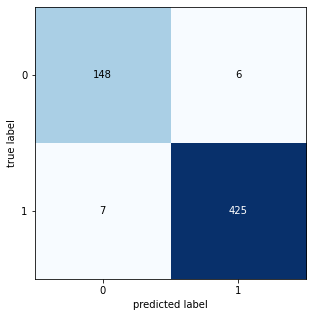

In [347]:
CM = confusion_matrix(y_test, y_pred)
fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(5, 5))
plt.show()

In [348]:
precision, recall, F1_score = get_scores(y_test, y_pred)

print (f"recall = {recall:05f}")
print (f"precision = {precision:05f}")
print (f"F1_score = {F1_score:05f}")

recall = 0.983796
precision = 0.986079
F1_score = 0.984936


# 4) Misprediction analysis

In [349]:
label = ["Normal", "Pneumonia"]
for num in range(y_test.shape[0]):
    if (y_test[num, 0] != y_pred[num, 0]):
        print (f"img {num} : Predicted {label[y_pred[num, 0]]} instead of {label[y_test[num, 0]]}")

img 17 : Predicted Normal instead of Pneumonia
img 24 : Predicted Pneumonia instead of Normal
img 30 : Predicted Pneumonia instead of Normal
img 203 : Predicted Normal instead of Pneumonia
img 219 : Predicted Pneumonia instead of Normal
img 257 : Predicted Pneumonia instead of Normal
img 258 : Predicted Normal instead of Pneumonia
img 338 : Predicted Pneumonia instead of Normal
img 382 : Predicted Normal instead of Pneumonia
img 431 : Predicted Normal instead of Pneumonia
img 436 : Predicted Normal instead of Pneumonia
img 489 : Predicted Pneumonia instead of Normal
img 533 : Predicted Normal instead of Pneumonia


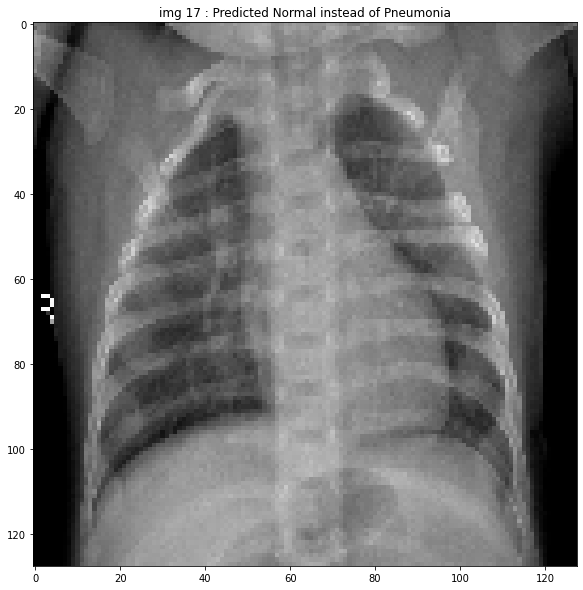

In [335]:
#Let's look at these mispredictions
num = 17 #Change this number. The mispredictions appears above

plt.figure(figsize=(10, 10))
if y_true[num, 0] != y_pred[num, 0]:
    plt.title(f"img {num} : Predicted {label[y_pred[num, 0]]} instead of {label[y_test[num, 0]]}")
else:
    plt.title(f"img {num} : Good prediction : {label[y_pred[num, 0]]}")
plt.imshow(X_test[num])